In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [5]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Density [log 10 g/cm^2]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [6]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [7]:
field = "density"
axis = "y" 
width = 200 #[kpc]
resolution = 70 #[pixel]
colorlabel = 'Density [log 10 g/cm^2]'
max_radius = width/2 #[kpc]
min_radius = 0  #[kpc]
binsize = 1.5 #[kpc]
markersize = 10
fontsize = 20 
plotlabel_linedot = 'Binned mean density'
plotlabel_segment = 'Fitted density'

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0138/DD0138


yt : [INFO     ] 2023-07-17 14:31:35,743 Parameters: current_time              = 67.566527818285
yt : [INFO     ] 2023-07-17 14:31:35,744 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:31:35,744 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:31:35,745 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:31:35,746 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:31:35,747 Parameters: current_redshift          = 4.2560468529995
yt : [INFO     ] 2023-07-17 14:31:35,748 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:31:35,750 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:31:35,751 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 14:31:35,751 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:     col1      col2     col3     col4     col5     col6     col7   col8
----------- -------- -------- -------- -------- -------- -------- ----
4.256046853 0.494908 0.492937 0.500048 0.496908 0.494937 0.502048    9


Parsing Hierarchy : 100%|█████████████████| 5116/5116 [00:00<00:00, 8652.82it/s]
yt : [INFO     ] 2023-07-17 14:31:36,629 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:32:59,876 Projection completed
yt : [INFO     ] 2023-07-17 14:32:59,880 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/var/folders/d8/fhyrhkwj0gn9mv61yhxy4srw0005m7/T/ipykernel_16982/1734569642.py:19: RuntimeWarning: divide by zero encountered in log10
  p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist))
yt : [INFO     ] 2023-07-17 14:33:00,116 Parameters: current_time              = 92.566527818285


Error with DD0138
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0238/DD0238


yt : [INFO     ] 2023-07-17 14:33:00,117 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:33:00,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:33:00,118 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:33:00,119 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:33:00,120 Parameters: current_redshift          = 3.2538800161868
yt : [INFO     ] 2023-07-17 14:33:00,121 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:33:00,121 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:33:00,122 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 14:33:00,123 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
3.25388001619 0.494301 0.491267 0.500132 0.496301 0.493267 0.502132    9


Parsing Hierarchy : 100%|██████████████| 11675/11675 [00:01<00:00, 11084.41it/s]
yt : [INFO     ] 2023-07-17 14:33:01,548 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:35:50,811 Projection completed
yt : [INFO     ] 2023-07-17 14:35:50,813 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
yt : [INFO     ] 2023-07-17 14:35:50,945 Parameters: current_time              = 104.81652781829
yt : [INFO     ] 2023-07-17 14:35:50,945 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:35:50,946 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:35:50,946 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:35:50,947 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:35:50,948 Parameters: current_redshift          = 2.9116806075987
yt : [INFO     ] 2023-07-17 14:35:50,949 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:35:50,949 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:35:50,950 Parameters: omega_radiation           = 0.0
yt : [INFO     ]

Error with DD0238
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0287/DD0287
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
2.9116806076 0.493954 0.490721 0.500203 0.495954 0.492721 0.502203    9


Parsing Hierarchy : 100%|████████████████| 7384/7384 [00:00<00:00, 11007.07it/s]
yt : [INFO     ] 2023-07-17 14:35:51,887 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:37:29,461 Projection completed
yt : [INFO     ] 2023-07-17 14:37:29,462 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
yt : [INFO     ] 2023-07-17 14:37:29,587 Parameters: current_time              = 106.31652781829
yt : [INFO     ] 2023-07-17 14:37:29,587 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:37:29,588 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:37:29,589 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:37:29,590 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:37:29,590 Parameters: current_redshift          = 2.8742891413864
yt : [INFO     ] 2023-07-17 14:37:29,591 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:37:29,592 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:37:29,592 Parameters: omega_radiation           = 0.0
yt : [INFO     ]

Error with DD0287
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0293/DD0293
get_refine_box: using this location:      col1       col2     col3     col4    col5     col6     col7  col8
------------- -------- -------- ------- -------- -------- ------- ----
2.87428914139 0.493962 0.490687 0.50017 0.495962 0.492687 0.50217    9


Parsing Hierarchy : 100%|█████████████████| 7297/7297 [00:00<00:00, 7920.48it/s]
yt : [INFO     ] 2023-07-17 14:37:31,251 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:39:07,428 Projection completed
yt : [INFO     ] 2023-07-17 14:39:07,429 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
yt : [INFO     ] 2023-07-17 14:39:07,549 Parameters: current_time              = 117.56652781829
yt : [INFO     ] 2023-07-17 14:39:07,550 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:39:07,550 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:39:07,551 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:39:07,551 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:39:07,552 Parameters: current_redshift          = 2.6192132579666
yt : [INFO     ] 2023-07-17 14:39:07,553 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:39:07,554 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:39:07,554 Parameters: omega_radiation           = 0.0
yt : [INFO     ]

Error with DD0293
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0338/DD0338
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.61921325797 0.493773 0.490067 0.500353 0.495773 0.492067 0.502353    9


Parsing Hierarchy : 100%|████████████████| 8624/8624 [00:00<00:00, 11763.32it/s]
yt : [INFO     ] 2023-07-17 14:39:08,568 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:42:37,237 Projection completed
yt : [INFO     ] 2023-07-17 14:42:37,238 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


Error with DD0338
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0438/DD0438


yt : [INFO     ] 2023-07-17 14:42:37,561 Parameters: current_time              = 142.56652781829
yt : [INFO     ] 2023-07-17 14:42:37,561 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:42:37,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:42:37,563 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:42:37,563 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:42:37,563 Parameters: current_redshift          = 2.174064272558
yt : [INFO     ] 2023-07-17 14:42:37,564 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:42:37,565 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:42:37,565 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 14:42:37,566 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.17406427256 0.493252 0.488579 0.500941 0.495252 0.490579 0.502941    9


Parsing Hierarchy : 100%|█████████████████| 9619/9619 [00:01<00:00, 6284.89it/s]
yt : [INFO     ] 2023-07-17 14:42:39,438 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:46:32,787 Projection completed
yt : [INFO     ] 2023-07-17 14:46:32,788 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


Error with DD0438
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0538/DD0538


yt : [INFO     ] 2023-07-17 14:46:33,216 Parameters: current_time              = 167.56652781829
yt : [INFO     ] 2023-07-17 14:46:33,217 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:46:33,218 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:46:33,219 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:46:33,219 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:46:33,220 Parameters: current_redshift          = 1.8407728906142
yt : [INFO     ] 2023-07-17 14:46:33,221 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:46:33,222 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:46:33,223 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 14:46:33,223 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.84077289061 0.492796 0.487204 0.501442 0.494796 0.489204 0.503442    9


Parsing Hierarchy : 100%|█████████████████| 6003/6003 [00:00<00:00, 6552.56it/s]
yt : [INFO     ] 2023-07-17 14:46:34,386 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:49:26,035 Projection completed
yt : [INFO     ] 2023-07-17 14:49:26,036 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


Error with DD0538
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0638/DD0638


yt : [INFO     ] 2023-07-17 14:49:26,395 Parameters: current_time              = 192.56652781829
yt : [INFO     ] 2023-07-17 14:49:26,396 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:49:26,397 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:49:26,398 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:49:26,398 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:49:26,399 Parameters: current_redshift          = 1.5796008591072
yt : [INFO     ] 2023-07-17 14:49:26,400 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:49:26,401 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:49:26,402 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 14:49:26,402 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.57960085911 0.49248 0.485831 0.501973 0.49448 0.487831 0.503973    9


Parsing Hierarchy : 100%|█████████████████| 7363/7363 [00:00<00:00, 8084.95it/s]
yt : [INFO     ] 2023-07-17 14:49:27,639 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:52:59,228 Projection completed
yt : [INFO     ] 2023-07-17 14:52:59,229 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


Error with DD0638
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0738/DD0738


yt : [INFO     ] 2023-07-17 14:52:59,520 Parameters: current_time              = 217.56652781829
yt : [INFO     ] 2023-07-17 14:52:59,521 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:52:59,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:52:59,522 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:52:59,523 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:52:59,524 Parameters: current_redshift          = 1.3679320867642
yt : [INFO     ] 2023-07-17 14:52:59,524 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:52:59,525 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:52:59,525 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 14:52:59,526 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2    col3     col4    col5    col6     col7  col8
------------- ------- -------- ------- ------- -------- ------- ----
1.36793208676 0.49219 0.484532 0.50256 0.49419 0.486532 0.50456    9


Parsing Hierarchy : 100%|█████████████████| 8207/8207 [00:01<00:00, 7117.88it/s]
yt : [INFO     ] 2023-07-17 14:53:01,005 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:56:33,357 Projection completed
yt : [INFO     ] 2023-07-17 14:56:33,359 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


Error with DD0738
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0838/DD0838


yt : [INFO     ] 2023-07-17 14:56:33,891 Parameters: current_time              = 242.56652781829
yt : [INFO     ] 2023-07-17 14:56:33,892 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:56:33,893 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:56:33,894 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:56:33,895 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:56:33,896 Parameters: current_redshift          = 1.1918720434881
yt : [INFO     ] 2023-07-17 14:56:33,897 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:56:33,898 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:56:33,899 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 14:56:33,900 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.19187204349 0.49185 0.483393 0.503033 0.49385 0.485393 0.505033    9


Parsing Hierarchy : 100%|█████████████████| 6414/6414 [00:01<00:00, 4866.94it/s]
yt : [INFO     ] 2023-07-17 14:56:35,485 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 14:59:16,629 Projection completed
yt : [INFO     ] 2023-07-17 14:59:16,630 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


Error with DD0838
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0938/DD0938


yt : [INFO     ] 2023-07-17 14:59:17,164 Parameters: current_time              = 267.56652781829
yt : [INFO     ] 2023-07-17 14:59:17,165 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 14:59:17,165 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 14:59:17,166 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 14:59:17,167 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 14:59:17,168 Parameters: current_redshift          = 1.0423765498971
yt : [INFO     ] 2023-07-17 14:59:17,169 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 14:59:17,169 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 14:59:17,170 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 14:59:17,171 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
1.0423765499 0.491558 0.482256 0.503483 0.493558 0.484256 0.505483    9


Parsing Hierarchy : 100%|█████████████████| 6646/6646 [00:00<00:00, 8208.52it/s]
yt : [INFO     ] 2023-07-17 14:59:18,222 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:02:07,323 Projection completed
yt : [INFO     ] 2023-07-17 15:02:07,324 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


Error with DD0938
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1038/DD1038


yt : [INFO     ] 2023-07-17 15:02:07,748 Parameters: current_time              = 292.31652781829
yt : [INFO     ] 2023-07-17 15:02:07,749 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:02:07,749 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:02:07,750 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:02:07,751 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:02:07,751 Parameters: current_redshift          = 0.91449134314195
yt : [INFO     ] 2023-07-17 15:02:07,752 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:02:07,753 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:02:07,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:02:07,754 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1        col2     col3     col4     col5     col6     col7   col8
-------------- -------- -------- -------- -------- -------- -------- ----
0.914491343142 0.491324 0.481173 0.503918 0.493324 0.483173 0.505918    9


Parsing Hierarchy : 100%|█████████████████| 5369/5369 [00:00<00:00, 5490.01it/s]
yt : [INFO     ] 2023-07-17 15:02:08,983 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:04:29,801 Projection completed
yt : [INFO     ] 2023-07-17 15:04:29,802 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


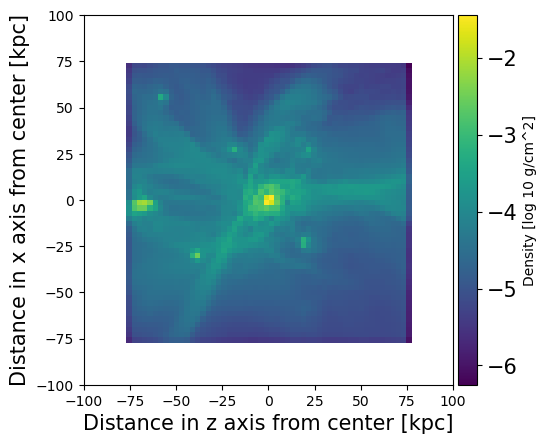

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1138/DD1138


yt : [INFO     ] 2023-07-17 15:04:30,753 Parameters: current_time              = 317.31652781829
yt : [INFO     ] 2023-07-17 15:04:30,754 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:04:30,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:04:30,755 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:04:30,756 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:04:30,757 Parameters: current_redshift          = 0.80131183964773
yt : [INFO     ] 2023-07-17 15:04:30,757 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:04:30,758 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:04:30,759 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:04:30,759 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3    col4     col5    col6    col7   col8
---------------- ------- ------- -------- ------- ------- -------- ----
0.80131183964773 0.49111 0.48016 0.504261 0.49311 0.48216 0.506261    9


Parsing Hierarchy : 100%|█████████████████| 5629/5629 [00:01<00:00, 3794.21it/s]
yt : [INFO     ] 2023-07-17 15:04:32,505 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:06:54,747 Projection completed
yt : [INFO     ] 2023-07-17 15:06:54,748 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


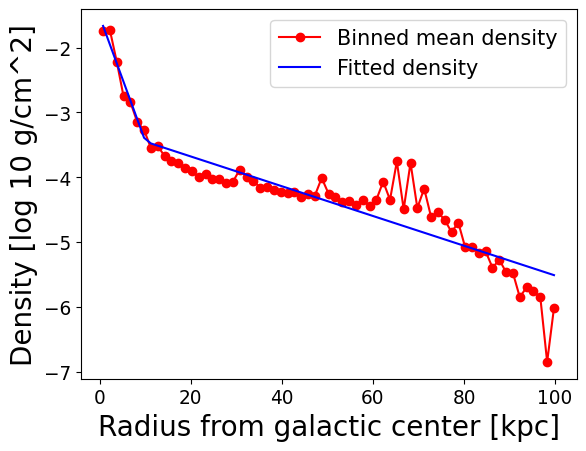

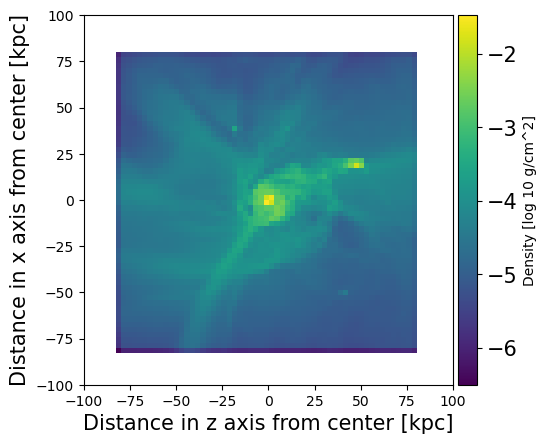

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1238/DD1238


yt : [INFO     ] 2023-07-17 15:06:55,645 Parameters: current_time              = 342.31652781829
yt : [INFO     ] 2023-07-17 15:06:55,645 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:06:55,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:06:55,647 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:06:55,648 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:06:55,649 Parameters: current_redshift          = 0.70104740107777
yt : [INFO     ] 2023-07-17 15:06:55,649 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:06:55,650 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:06:55,651 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:06:55,652 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.70104740107777 0.49091 0.479176 0.504679 0.49291 0.481176 0.506679    9


Parsing Hierarchy : 100%|█████████████████| 6009/6009 [00:00<00:00, 8370.50it/s]
yt : [INFO     ] 2023-07-17 15:06:56,698 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:09:28,572 Projection completed
yt : [INFO     ] 2023-07-17 15:09:28,573 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


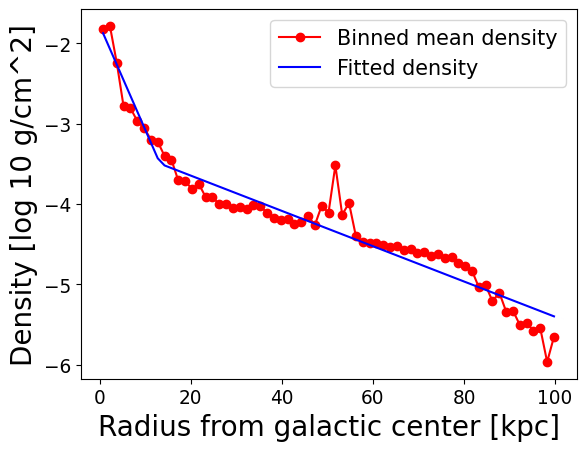

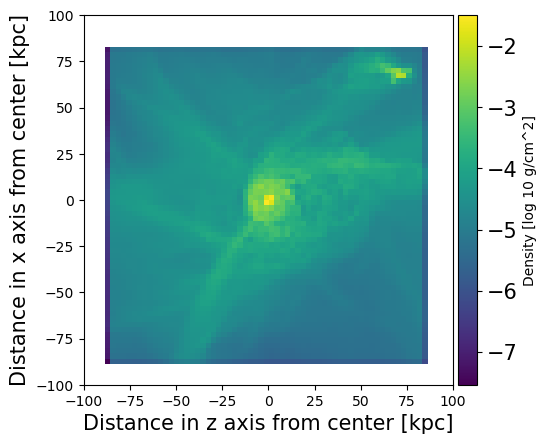

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1338/DD1338


yt : [INFO     ] 2023-07-17 15:09:29,579 Parameters: current_time              = 367.31652781829
yt : [INFO     ] 2023-07-17 15:09:29,580 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:09:29,580 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:09:29,581 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:09:29,582 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:09:29,583 Parameters: current_redshift          = 0.61132831909135
yt : [INFO     ] 2023-07-17 15:09:29,583 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:09:29,584 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:09:29,585 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:09:29,586 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3    col4     col5     col6    col7   col8
---------------- -------- ------- -------- -------- ------- -------- ----
0.61132831909135 0.490681 0.47823 0.505093 0.492681 0.48023 0.507093    9


Parsing Hierarchy : 100%|█████████████████| 6366/6366 [00:00<00:00, 7498.43it/s]
yt : [INFO     ] 2023-07-17 15:09:31,225 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:12:09,686 Projection completed
yt : [INFO     ] 2023-07-17 15:12:09,688 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


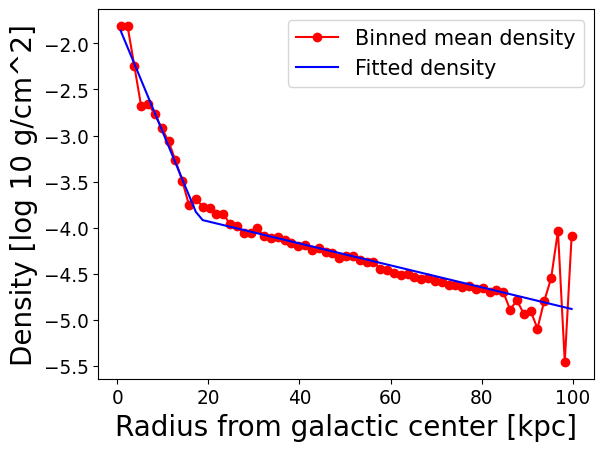

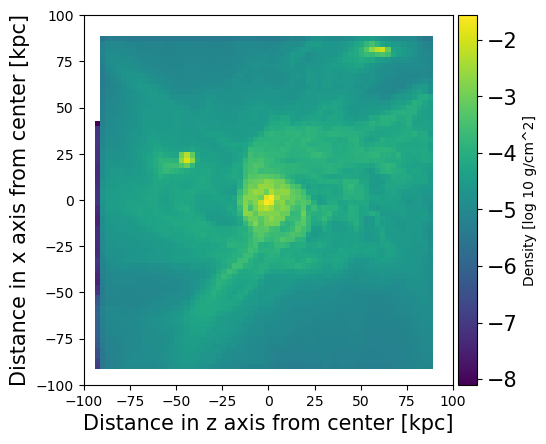

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1438/DD1438


yt : [INFO     ] 2023-07-17 15:12:10,638 Parameters: current_time              = 392.31652781829
yt : [INFO     ] 2023-07-17 15:12:10,638 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:12:10,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:12:10,640 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:12:10,641 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:12:10,642 Parameters: current_redshift          = 0.53034842583426
yt : [INFO     ] 2023-07-17 15:12:10,643 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:12:10,643 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:12:10,644 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:12:10,645 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.53034842583426 0.490464 0.477354 0.505497 0.492464 0.479354 0.507497    9


Parsing Hierarchy : 100%|█████████████████| 6029/6029 [00:00<00:00, 8164.78it/s]
yt : [INFO     ] 2023-07-17 15:12:11,700 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:14:45,322 Projection completed
yt : [INFO     ] 2023-07-17 15:14:45,323 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


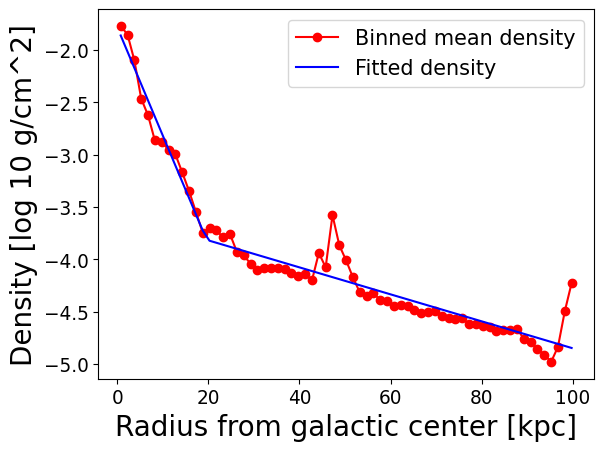

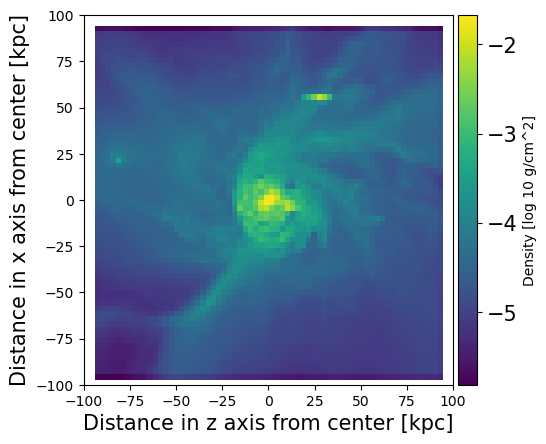

yt : [INFO     ] 2023-07-17 15:14:45,913 Parameters: current_time              = 402.06652781829
yt : [INFO     ] 2023-07-17 15:14:45,913 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:14:45,914 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:14:45,915 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:14:45,916 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:14:45,917 Parameters: current_redshift          = 0.50082158855578
yt : [INFO     ] 2023-07-17 15:14:45,917 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:14:45,918 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:14:45,919 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:14:45,920 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1477/DD1477
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.50082158855578 0.490382 0.477019 0.505663 0.492382 0.479019 0.507663    9


Parsing Hierarchy : 100%|█████████████████| 6066/6066 [00:00<00:00, 7745.89it/s]
yt : [INFO     ] 2023-07-17 15:14:46,984 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:17:40,502 Projection completed
yt : [INFO     ] 2023-07-17 15:17:40,504 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


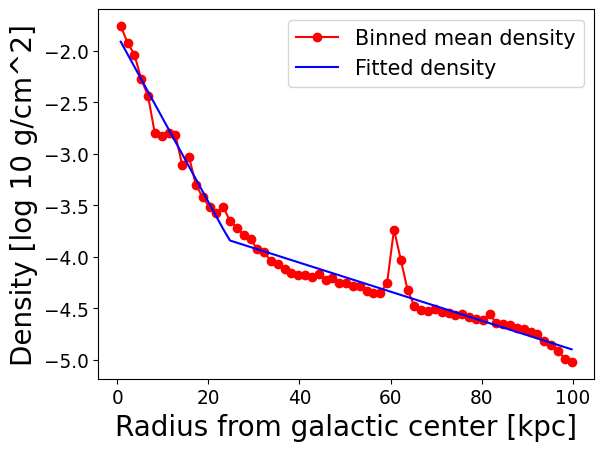

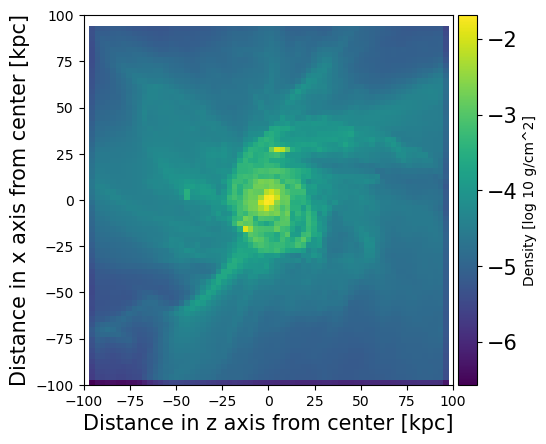

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1478/DD1478


yt : [INFO     ] 2023-07-17 15:17:41,352 Parameters: current_time              = 402.31652781829
yt : [INFO     ] 2023-07-17 15:17:41,353 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:17:41,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:17:41,355 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:17:41,355 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:17:41,356 Parameters: current_redshift          = 0.50007848881181
yt : [INFO     ] 2023-07-17 15:17:41,357 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:17:41,358 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:17:41,358 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:17:41,359 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.50007848881181 0.49038 0.477011 0.505667 0.49238 0.479011 0.507667    9


Parsing Hierarchy : 100%|█████████████████| 5947/5947 [00:00<00:00, 6012.00it/s]
yt : [INFO     ] 2023-07-17 15:17:42,579 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:20:31,829 Projection completed
yt : [INFO     ] 2023-07-17 15:20:31,831 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


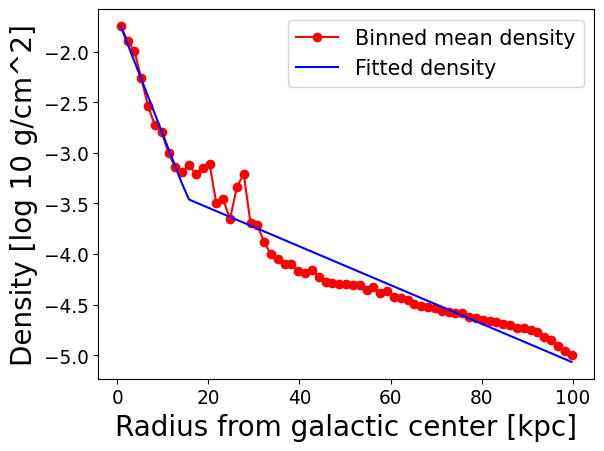

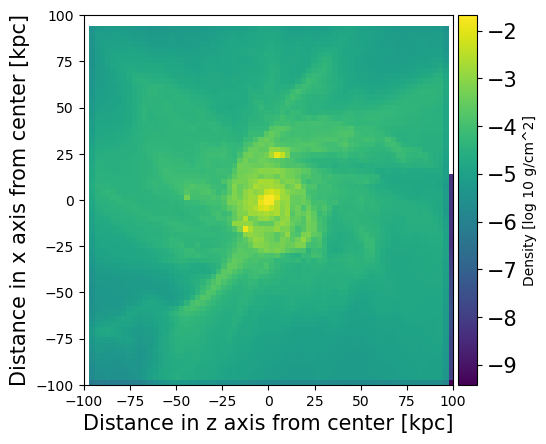

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1479/DD1479


yt : [INFO     ] 2023-07-17 15:20:32,732 Parameters: current_time              = 402.56652517609
yt : [INFO     ] 2023-07-17 15:20:32,733 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:20:32,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:20:32,735 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:20:32,736 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:20:32,736 Parameters: current_redshift          = 0.49933608114367
yt : [INFO     ] 2023-07-17 15:20:32,737 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:20:32,738 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:20:32,739 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:20:32,739 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.49933608114367 0.490378 0.477002 0.505671 0.492378 0.479002 0.507671    9


Parsing Hierarchy : 100%|█████████████████| 5985/5985 [00:00<00:00, 6075.48it/s]
yt : [INFO     ] 2023-07-17 15:20:34,380 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:23:23,776 Projection completed
yt : [INFO     ] 2023-07-17 15:23:23,777 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


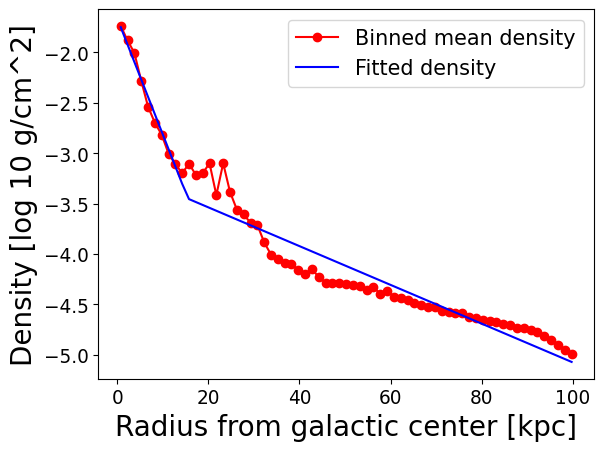

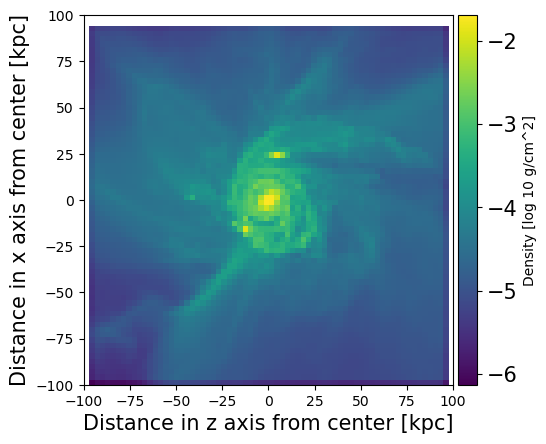

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1538/DD1538


yt : [INFO     ] 2023-07-17 15:23:24,755 Parameters: current_time              = 417.31652781829
yt : [INFO     ] 2023-07-17 15:23:24,756 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:23:24,756 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:23:24,757 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:23:24,757 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:23:24,758 Parameters: current_redshift          = 0.45670560906839
yt : [INFO     ] 2023-07-17 15:23:24,759 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:23:24,759 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:23:24,760 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-17 15:23:24,761 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.45670560906839 0.490252 0.476517 0.505875 0.492252 0.478517 0.507875    9


Parsing Hierarchy : 100%|█████████████████| 6119/6119 [00:00<00:00, 7931.14it/s]
yt : [INFO     ] 2023-07-17 15:23:25,763 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:25:56,135 Projection completed
yt : [INFO     ] 2023-07-17 15:25:56,140 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


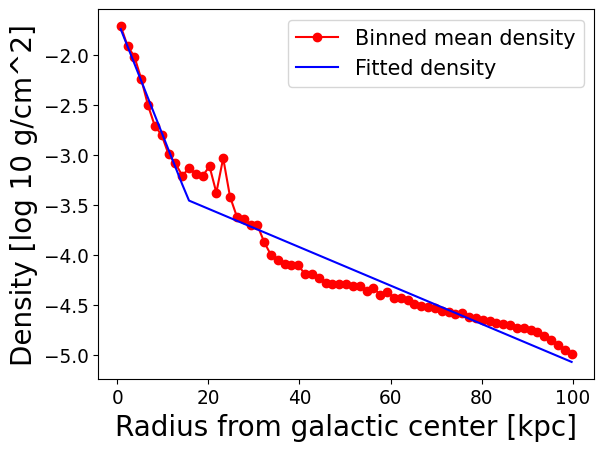

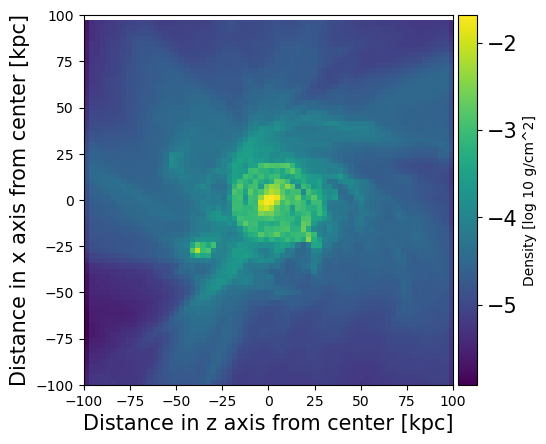

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1638/DD1638


yt : [INFO     ] 2023-07-17 15:25:57,066 Parameters: current_time              = 442.31652781829
yt : [INFO     ] 2023-07-17 15:25:57,067 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:25:57,067 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:25:57,068 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:25:57,068 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:25:57,069 Parameters: current_redshift          = 0.3892837031507
yt : [INFO     ] 2023-07-17 15:25:57,070 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:25:57,070 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:25:57,071 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:25:57,071 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.38929394169243 0.490071 0.475697 0.506226 0.492071 0.477697 0.508226    9


Parsing Hierarchy : 100%|█████████████████| 5613/5613 [00:00<00:00, 6622.00it/s]
yt : [INFO     ] 2023-07-17 15:25:58,188 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:28:17,849 Projection completed
yt : [INFO     ] 2023-07-17 15:28:17,851 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


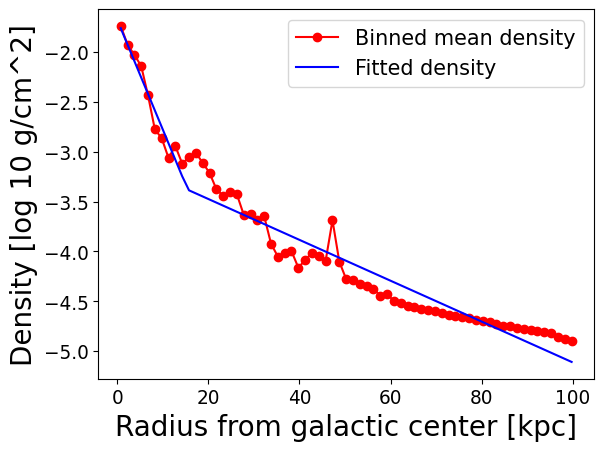

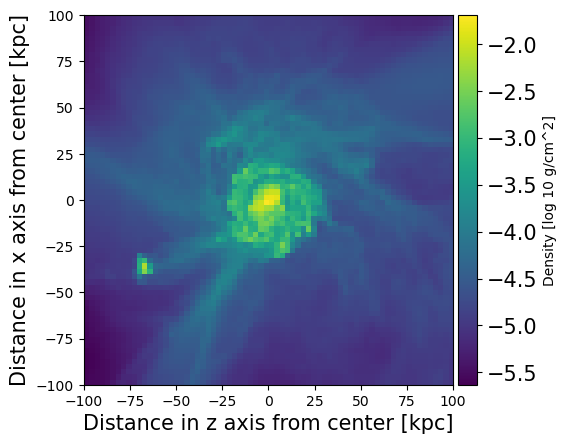

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1738/DD1738


yt : [INFO     ] 2023-07-17 15:28:18,663 Parameters: current_time              = 467.31652781829
yt : [INFO     ] 2023-07-17 15:28:18,664 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:28:18,664 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:28:18,665 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:28:18,667 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:28:18,667 Parameters: current_redshift          = 0.32721407621449
yt : [INFO     ] 2023-07-17 15:28:18,668 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:28:18,669 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:28:18,670 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:28:18,670 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.32722883488872 0.489878 0.474896 0.506564 0.491878 0.476896 0.508564    9


Parsing Hierarchy : 100%|█████████████████| 5309/5309 [00:00<00:00, 7289.43it/s]
yt : [INFO     ] 2023-07-17 15:28:19,616 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:30:25,584 Projection completed
yt : [INFO     ] 2023-07-17 15:30:25,586 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


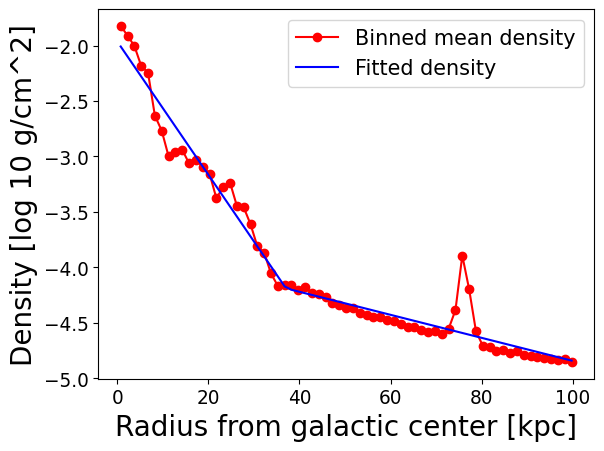

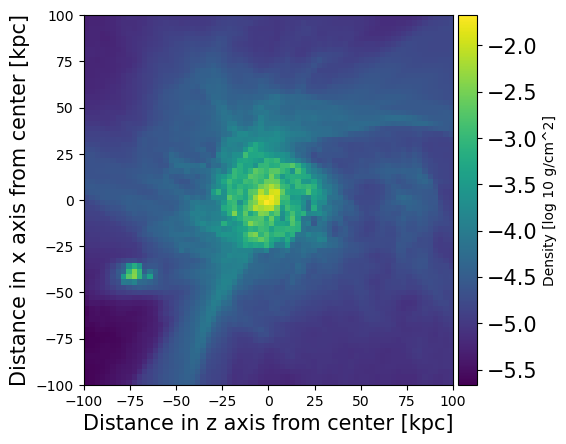

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1838/DD1838


yt : [INFO     ] 2023-07-17 15:30:26,497 Parameters: current_time              = 492.31652781829
yt : [INFO     ] 2023-07-17 15:30:26,498 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:30:26,499 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:30:26,499 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:30:26,500 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:30:26,501 Parameters: current_redshift          = 0.26978215732692
yt : [INFO     ] 2023-07-17 15:30:26,502 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:30:26,503 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:30:26,504 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:30:26,504 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1        col2     col3     col4     col5     col6     col7   col8
--------------- -------- -------- -------- -------- -------- -------- ----
0.2697939304999 0.489703 0.474121 0.506863 0.491703 0.476121 0.508863    9


Parsing Hierarchy : 100%|█████████████████| 5365/5365 [00:00<00:00, 6457.44it/s]
yt : [INFO     ] 2023-07-17 15:30:27,557 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:32:58,613 Projection completed
yt : [INFO     ] 2023-07-17 15:32:58,615 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


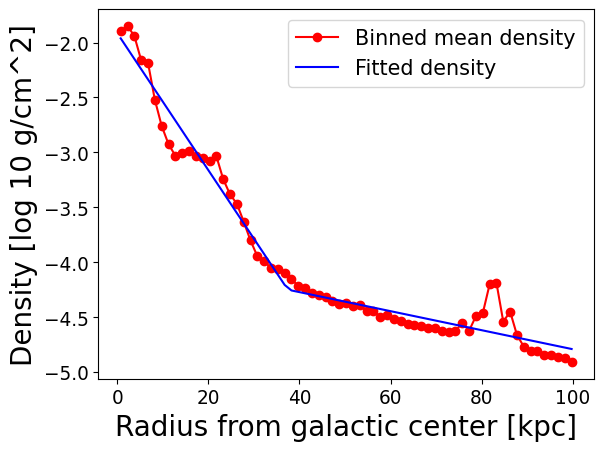

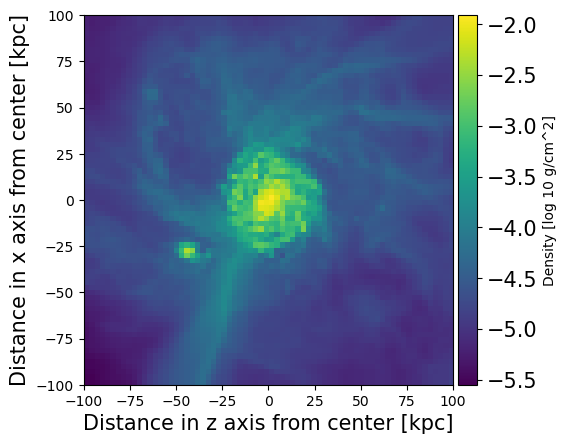

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1938/DD1938


yt : [INFO     ] 2023-07-17 15:32:59,610 Parameters: current_time              = 517.31652781829
yt : [INFO     ] 2023-07-17 15:32:59,610 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:32:59,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:32:59,612 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:32:59,613 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:32:59,614 Parameters: current_redshift          = 0.21639444449422
yt : [INFO     ] 2023-07-17 15:32:59,614 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:32:59,615 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:32:59,616 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:32:59,616 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.21640266677445 0.489548 0.473393 0.507161 0.491548 0.475393 0.509161    9


Parsing Hierarchy : 100%|█████████████████| 4944/4944 [00:00<00:00, 5120.76it/s]
yt : [INFO     ] 2023-07-17 15:33:00,845 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:35:26,449 Projection completed
yt : [INFO     ] 2023-07-17 15:35:26,450 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


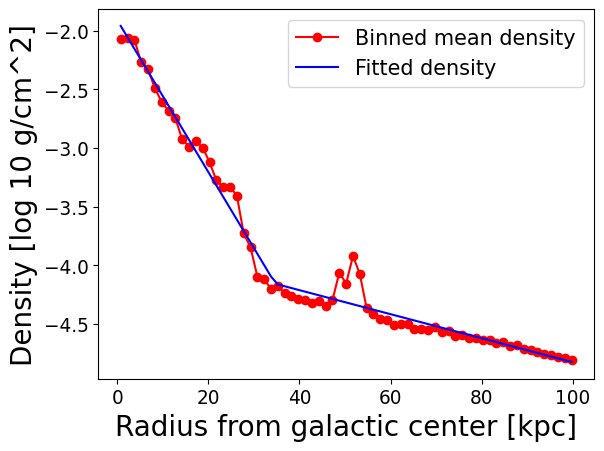

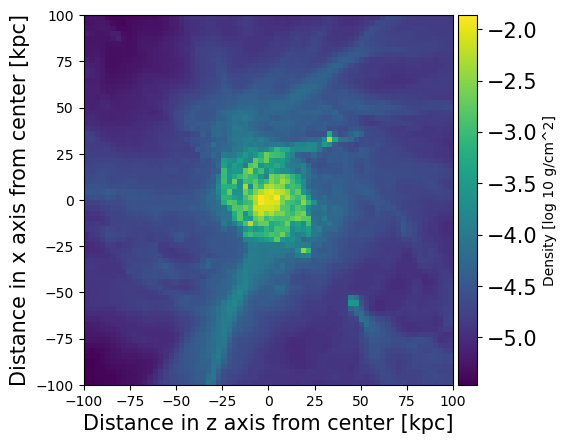

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2038/DD2038


yt : [INFO     ] 2023-07-17 15:35:27,365 Parameters: current_time              = 542.31652781829
yt : [INFO     ] 2023-07-17 15:35:27,365 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:35:27,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:35:27,367 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:35:27,368 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:35:27,368 Parameters: current_redshift          = 0.1665627895111
yt : [INFO     ] 2023-07-17 15:35:27,369 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:35:27,370 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:35:27,370 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:35:27,371 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.16656997024797 0.489403 0.472708 0.507468 0.491403 0.474708 0.509468    9


Parsing Hierarchy : 100%|█████████████████| 5224/5224 [00:00<00:00, 6621.83it/s]
yt : [INFO     ] 2023-07-17 15:35:28,407 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:38:03,388 Projection completed
yt : [INFO     ] 2023-07-17 15:38:03,389 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


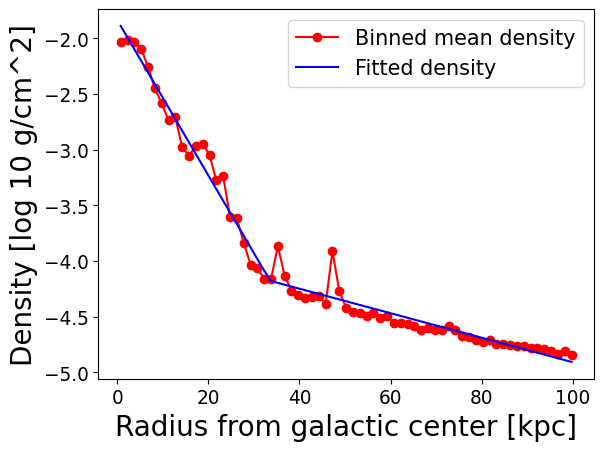

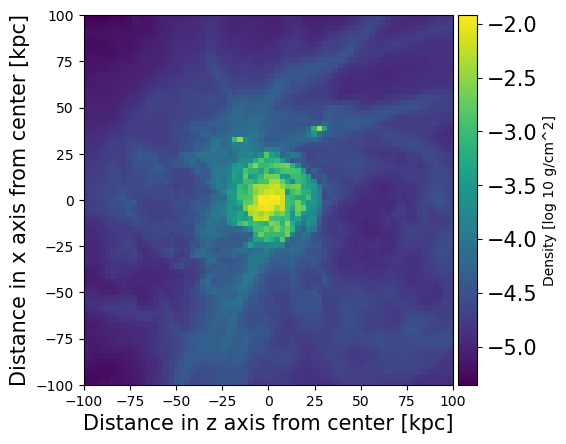

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2138/DD2138


yt : [INFO     ] 2023-07-17 15:38:04,266 Parameters: current_time              = 567.31652781829
yt : [INFO     ] 2023-07-17 15:38:04,267 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:38:04,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:38:04,268 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:38:04,269 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:38:04,270 Parameters: current_redshift          = 0.11988207020675
yt : [INFO     ] 2023-07-17 15:38:04,270 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:38:04,271 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:38:04,271 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:38:04,272 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.11989107535193 0.489254 0.472056 0.507771 0.491254 0.474056 0.509771    9


Parsing Hierarchy : 100%|█████████████████| 4682/4682 [00:01<00:00, 4313.63it/s]
yt : [INFO     ] 2023-07-17 15:38:05,699 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:40:32,511 Projection completed
yt : [INFO     ] 2023-07-17 15:40:32,512 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


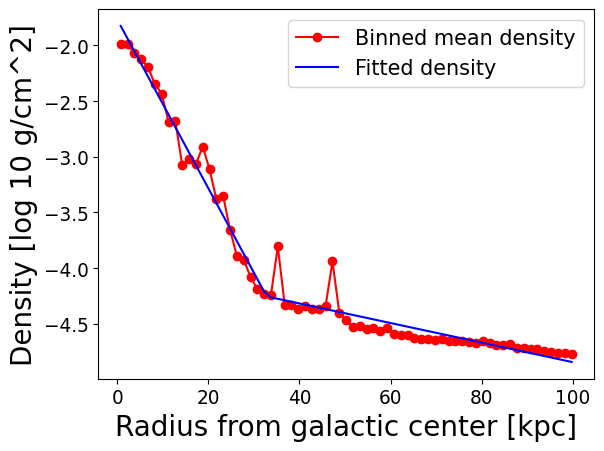

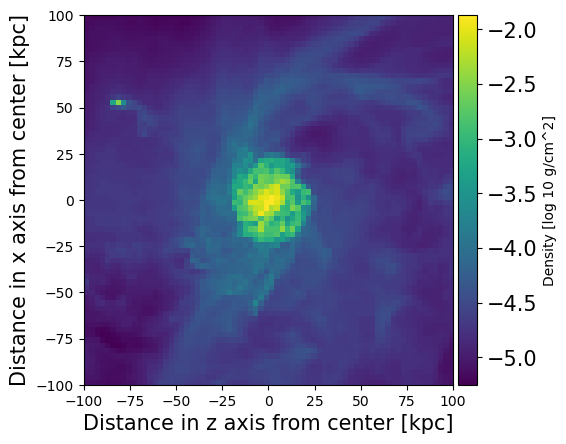

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2238/DD2238


yt : [INFO     ] 2023-07-17 15:40:33,566 Parameters: current_time              = 592.31652781829
yt : [INFO     ] 2023-07-17 15:40:33,567 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:40:33,568 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:40:33,568 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:40:33,569 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:40:33,570 Parameters: current_redshift          = 0.076013204837093
yt : [INFO     ] 2023-07-17 15:40:33,570 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:40:33,571 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:40:33,572 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:40:33,573 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.076025451160672 0.489123 0.471432 0.508053 0.491123 0.473432 0.510053    9


Parsing Hierarchy : 100%|█████████████████| 4688/4688 [00:00<00:00, 5335.69it/s]
yt : [INFO     ] 2023-07-17 15:40:34,726 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:42:39,294 Projection completed
yt : [INFO     ] 2023-07-17 15:42:39,296 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


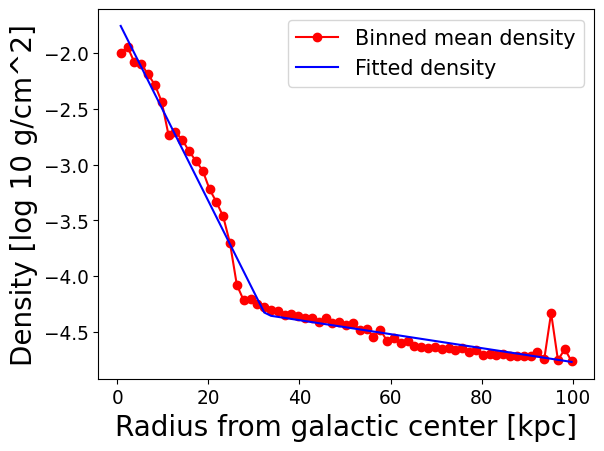

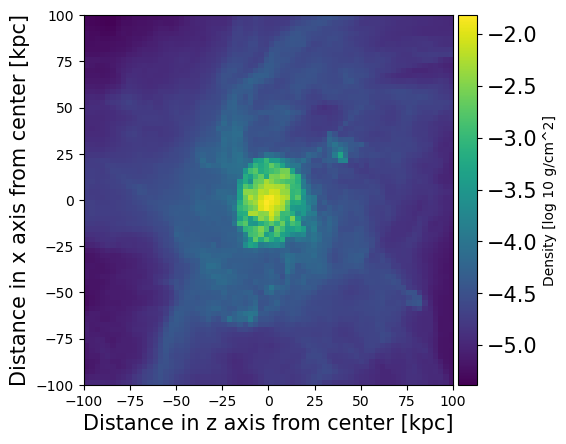

yt : [INFO     ] 2023-07-17 15:42:39,894 Parameters: current_time              = 604.81652781829
yt : [INFO     ] 2023-07-17 15:42:39,894 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:42:39,895 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:42:39,896 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:42:39,896 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:42:39,897 Parameters: current_redshift          = 0.055049291735707
yt : [INFO     ] 2023-07-17 15:42:39,898 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:42:39,898 Parameters: omega_matter              = 0.285


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2288/DD2288


yt : [INFO     ] 2023-07-17 15:42:39,899 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:42:39,900 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.055055663741937 0.489056 0.471131 0.508189 0.491056 0.473131 0.510189    9


Parsing Hierarchy : 100%|█████████████████| 4745/4745 [00:00<00:00, 5489.54it/s]
yt : [INFO     ] 2023-07-17 15:42:40,961 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:45:17,520 Projection completed
yt : [INFO     ] 2023-07-17 15:45:17,521 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


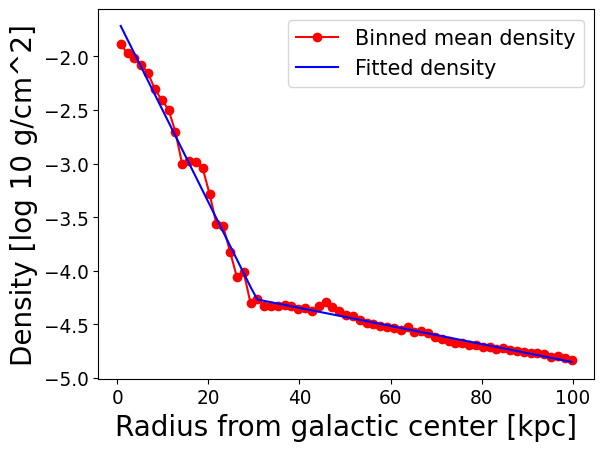

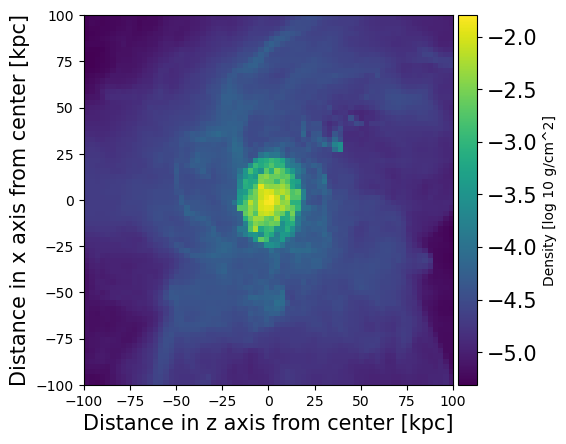

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2289/DD2289


yt : [INFO     ] 2023-07-17 15:45:18,412 Parameters: current_time              = 605.06652781829
yt : [INFO     ] 2023-07-17 15:45:18,413 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:45:18,413 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:45:18,414 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:45:18,415 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:45:18,416 Parameters: current_redshift          = 0.054634911934635
yt : [INFO     ] 2023-07-17 15:45:18,417 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:45:18,417 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:45:18,418 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:45:18,419 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.054642475638284 0.489054 0.471125 0.508191 0.491054 0.473125 0.510191    9


Parsing Hierarchy : 100%|█████████████████| 4798/4798 [00:00<00:00, 6029.85it/s]
yt : [INFO     ] 2023-07-17 15:45:19,802 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:47:52,932 Projection completed
yt : [INFO     ] 2023-07-17 15:47:52,934 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


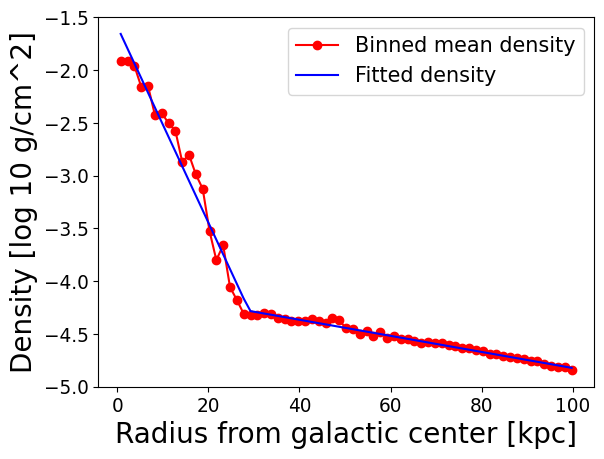

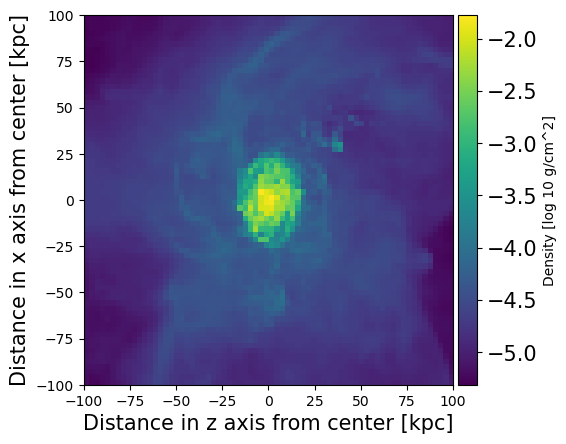

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2338/DD2338


yt : [INFO     ] 2023-07-17 15:47:53,788 Parameters: current_time              = 617.31652781829
yt : [INFO     ] 2023-07-17 15:47:53,788 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:47:53,789 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:47:53,790 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:47:53,790 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:47:53,791 Parameters: current_redshift          = 0.034670076640073
yt : [INFO     ] 2023-07-17 15:47:53,792 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:47:53,793 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:47:53,793 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:47:53,794 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4    col5     col6     col7  col8
----------------- -------- -------- ------- -------- -------- ------- ----
0.034684446722936 0.488987 0.470833 0.50832 0.490987 0.472833 0.51032    9


Parsing Hierarchy : 100%|█████████████████| 4505/4505 [00:00<00:00, 6281.18it/s]
yt : [INFO     ] 2023-07-17 15:47:54,697 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:49:52,616 Projection completed
yt : [INFO     ] 2023-07-17 15:49:52,617 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


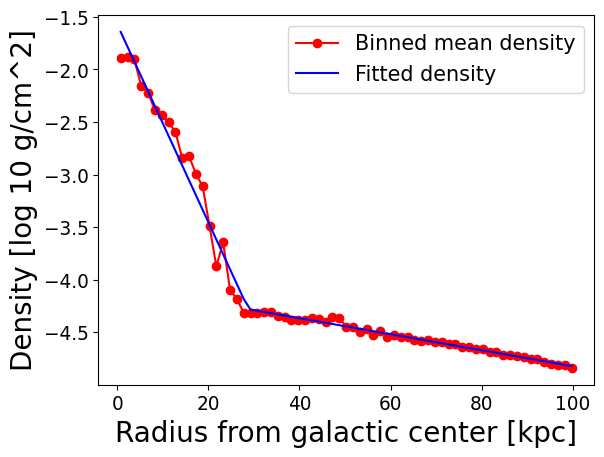

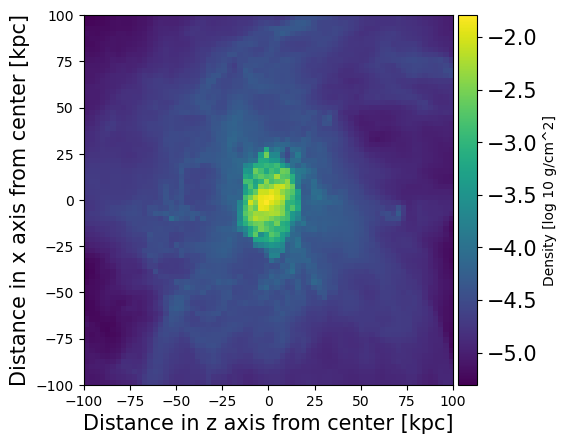

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2427/DD2427


yt : [INFO     ] 2023-07-17 15:49:53,627 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-07-17 15:49:53,628 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-17 15:49:53,628 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-17 15:49:53,629 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-17 15:49:53,629 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-17 15:49:53,630 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-07-17 15:49:53,631 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-17 15:49:53,632 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-17 15:49:53,632 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-17 15:49:53,633 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 5241.03it/s]
yt : [INFO     ] 2023-07-17 15:49:54,653 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-17 15:52:03,848 Projection completed
yt : [INFO     ] 2023-07-17 15:52:03,849 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


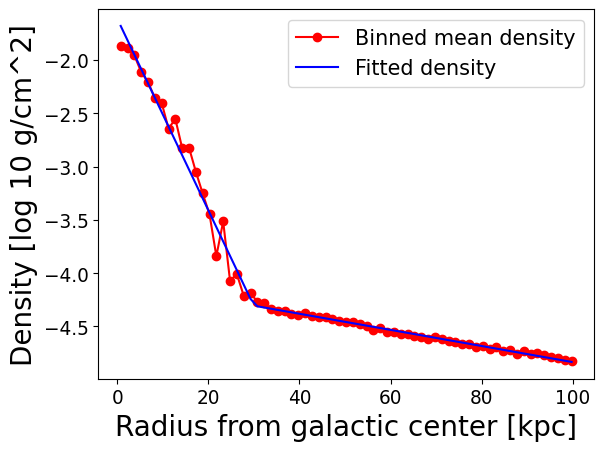

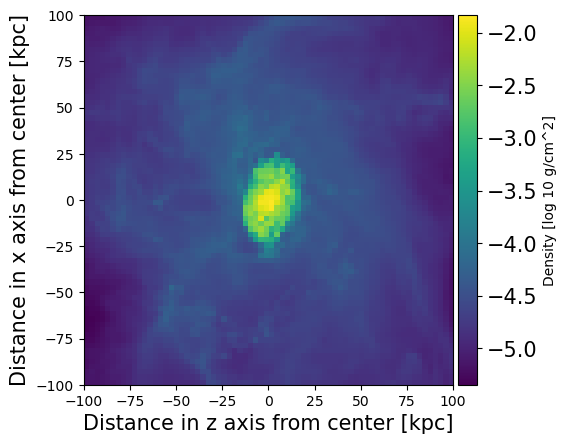

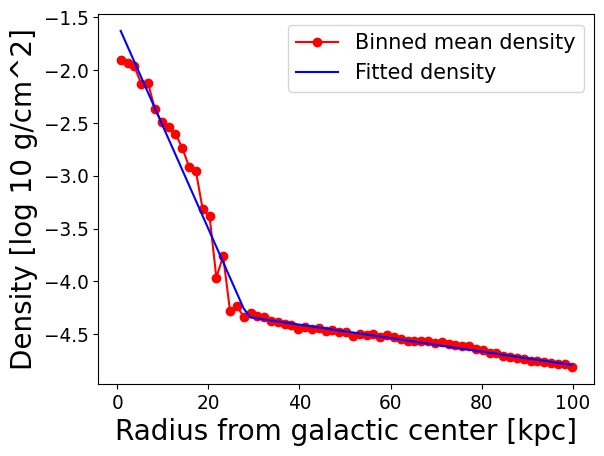

In [8]:
redshiftlist = []
cutofflist = []

for DD in sorted_dd_list:
    try:  
        snap = DD  # name of the snapshot output 
        snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives

        ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                     disk_relative=False, do_filter_particles=False, masses_dir=track_dir)

        frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)

        OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

        radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)


        p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist))
        #p : popt(optimization parameter) / e : pcov(covariance of popt)

        projection_plot = projection(frb, field, width, colorlabel, axis, fontsize = 15)
        segment_plot = plotting(radiuslist, np.log10(quantitylist), piecewise_linear(radiuslist, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)
 
        segment_plot.savefig(output_dir + snap + "_Density_Profile.jpg")
        projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")
    
        redpara = ds.get_parameter("CosmologyCurrentRedshift")
        redshiftlist.append(redpara) #[z]
        cutofflist.append(p[0]) #[kpc]
        
    except:
        print("Error with" +" "+ snap)
        pass     

In [16]:
len(redshiftlist)

20

In [12]:
len(cutofflist)

20

Text(0, 0.5, 'Redshift [z]')

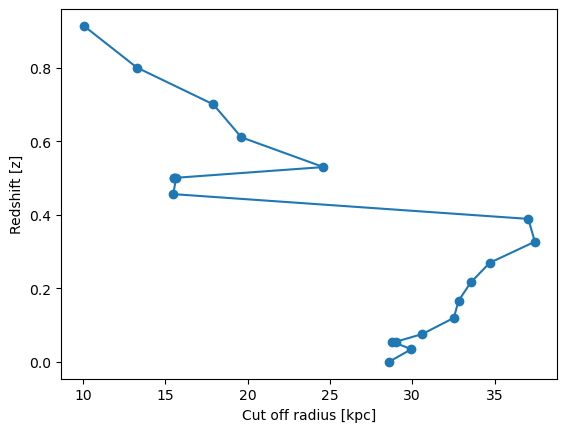

In [20]:
plt.plot(cutofflist,redshiftlist, '-o')
plt.xlabel("Cut off radius [kpc]")
plt.ylabel("Redshift [z]")

In [14]:
print(len(sorted_dd_list))

31
